# Readmission Prediction Project

## Project Definition - Project Overview

Hospitals often use 30-day readmissions as a measure to evaluate the quality of care provided by the hospital.  The goal of this metric is the reduce the number of 30-day readmissions by as much as possible.  The idea is that 30-day readmissions can be reduced by providing the patient with the appropriate care and the proper instructions on care after discharge.  It is expected that some patients with a higher acuity (sicker) patients have a higher likelihood of being readmitted within 30 days, but reducing readmissions as much as possible results in less unnecessary hospital care and a better overall patient experience.  Governmental agencies such as the Center for Medicare and Medicaid Services (CMS) produce a risk-adjusted rate that enables readmission rate comparison across different hospitals.

The project uses the MIMIC-III database that contains deidentified patient data for critical care hospital visits to the Beth Israel Deaconess Medical Center between 2001 and 2012.  In order to access the data, a request must be approved by the MIT Lab for Computational Physiology.

## Project Definition - Problem Statement

This goal is to create a prediction model that can identify admissions that will result in a non-elective readmission within 30 days of discharge.  The strategy solve this problem is the following:
1. Load the MIMIC-III dataset into a PostgresSQL database
2. ETL the admission data into a format for machine learning
3. Train and test a classification model
The final model is expected to be used for future hospital admissions.


## Project Definition - Metrics

Accuracy is the primary evaluation metric that will be used for this project. A secondary evaluation metric is the Receiver Operating Curve (ROC) Area Under the Curve (AUC) score.  

## Methodology - Data Preprocessing

### Load the Data

The data was loaded into a local PostgreSQL instance and the data was transformed for machine learning purposes.  These are the steps taken using SQL to generate the dataset:

1. Aggregated data at the admission level
2. Added LOS, emergency hours, icu_stays, age based on the date time fields
3. Added primary diagnosis and procedure
4. Added primary and secondary diagnosis in another set
5. Added the readmitted within 30 days flag
6. Added the cancer patient flag

### Query the Data

The data was queried using the psycopg2 library, which connects to the local PostgresSQL instance.  The data was extract using PL SQL and three datasets was loaded:

1.  The primary dataset for machine learning
2.  The secondary diagnoses data
3.  The secondary procedures data

Note: There can be many diagnoses and procedures associated with a single hospital stay.  Diagnosies and procedures are sequenced and the first one is considered the primary.  The others are all considered secondary and a hospital stay can have many secondary diagnoses and procedures.

In [1]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd

# connect to local postgressql instance
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password="Droid319", port=5433)

# load the primary dataset
data_query = open('initial dataset.sql', 'r')
data = pd.read_sql_query(data_query.read(), conn)

# load the secondary diagnoses and procedures
secondary_diag_query = open('secondary diagnoses.sql','r')
sec_diag_data = pd.read_sql_query(secondary_diag_query.read(), conn)

secondary_proc_query = open('secondary procedures.sql','r')
sec_proc_data = pd.read_sql_query(secondary_proc_query.read(), conn)

Review the primary dataset to ensure that the data was loaded property.

In [28]:
data.head(5)

,subject_id,hadm_id,admittime,dischtime,admission_type,admission_location,discharge_location,insurance,language,religion,...,primary_diag,diag_count,proc_count,visits_prior_30_days,non_elective_visits_prior_30_days,visits_prior_year,nonelective_visits_prior_year,cancer_flag,readmitted_flag,hospital_expire_flag
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,NOT SPECIFIED,...,"Single liveborn, born in hospital, delivered b...",3,1.0,0,0,0,0,0,0,0
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,CATHOLIC,...,Unspecified septicemia,9,6.0,0,0,0,0,0,0,0
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,...,Human immunodeficiency virus [HIV] disease,9,3.0,0,0,0,0,0,0,0
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,BUDDHIST,...,"Single liveborn, born in hospital, delivered w...",3,1.0,0,0,0,0,0,0,0
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,...,"Hypertensive chronic kidney disease, unspecifi...",8,5.0,0,0,0,0,0,0,0


### Data Transformation

Remove the subject_id, admittime, dischtime, and dob fields since these fields are not required or useful. For the time fields, the scrambling of the data makes it impossible to determine the sequence of hospital admissions.  

For the language, ethnicity, and religion fields, it would not be appropriate to analyze patients using this data.  The diagnosis field was removed since the primary and secondary diagnoses data will replace this field since this field appears free-form text.

In [29]:
data = data.drop(['subject_id','admittime','dischtime','language','ethnicity','religion','diagnosis','dob'], axis = 1)

Review the statistics for the numeric variables.

In [30]:
data.describe()

,hadm_id,los_days,emergency_hours,age,icu_days,diag_count,proc_count,visits_prior_30_days,non_elective_visits_prior_30_days,visits_prior_year,nonelective_visits_prior_year,cancer_flag,readmitted_flag,hospital_expire_flag
count,58916.000000,58916.000000,30875.000000,58916.000000,57771.000000,58916.000000,52228.000000,58916.000000,58916.000000,58916.000000,58916.000000,58916.000000,58916.000000,58916.000000
mean,149972.796524,10.122926,0.491087,64.053415,5.237194,11.047984,4.596443,0.449148,0.406392,0.449148,0.406392,0.055656,0.055605,0.098785
std,28882.691615,12.459323,0.289631,57.204052,10.114270,6.463037,3.823837,1.540330,1.509284,1.540330,1.509284,0.229257,0.229158,0.298375
min,100001.000000,-0.916667,-0.966667,0.000000,0.000200,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,124953.750000,3.750000,0.233333,43.000000,1.122500,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,149988.500000,6.458333,0.483333,61.000000,2.150200,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,174968.500000,11.791667,0.750000,75.000000,4.878050,15.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,199999.000000,294.625000,0.983333,311.000000,260.708900,39.000000,40.000000,41.000000,41.000000,41.000000,41.000000,1.000000,1.000000,1.000000


The emergency_hours, icu_days, and proc_count fields contain NaNs.  Since the record counts are lower than the other fields.

Replace the NaNs with zeros.

In [31]:
data['emergency_hours'] = data['emergency_hours'].fillna(0)
data['icu_days'] = data['icu_days'].fillna(0)
data['proc_count'] = data['proc_count'].fillna(0)

The los_days and emergency_hours fields contain negative values, which should not happen since a patient cannot stay for a negative amount of time.  It is assumed that this is simply bad data resulting from the date/time scrambling.

Review these negative values and then remove them from the dataset.

In [32]:
print('The number of los_days with negative values:')
print('The number of records with negative values for los_days: ' +  str(data[data['los_days'] < 0]['los_days'].count()))
print('The number of reocrds with negative values for emergency hours: ' + str(data[data['emergency_hours'] < 0]['los_days'].count()))
data = data[data['los_days'] >=0]
data = data[data['emergency_hours'] >=0]

The number of los_days with negative values:
The number of records with negative values for los_days: 82
The number of reocrds with negative values for emergency hours: 17


Review the statistic to confirm that the changes have been made.

In [33]:
# Review that all nans have been removed
print(data.describe())

             hadm_id      los_days  emergency_hours           age  \
count   58817.000000  58817.000000     58817.000000  58817.000000   
mean   149972.526191     10.137425         0.257538     64.045905   
std     28883.201189     12.462009         0.322408     57.201009   
min    100001.000000      0.000000         0.000000      0.000000   
25%    124952.000000      3.750000         0.000000     43.000000   
50%    149994.000000      6.458333         0.033333     61.000000   
75%    174968.000000     11.791667         0.516667     75.000000   
max    199999.000000    294.625000         0.983333    311.000000   

           icu_days    diag_count    proc_count  visits_prior_30_days  \
count  58817.000000  58817.000000  58817.000000          58817.000000   
mean       5.141673     11.053896      4.075403              0.448323   
std       10.047554      6.464998      3.885134              1.541342   
min        0.000000      0.000000      0.000000              0.000000   
25%        1.

There is one peculiar observation is that the max age is 311, which is unrealistic.  

Replace these max ages with the median.

In [34]:
age_median = data[data['age'] < 150]['age'].median()
data['age'] = data['age'].apply(lambda x: age_median if x > 150 else x)

Special characters are removed from the primary_diag, primary_proc, admission_location, discharge_location, and drg fields.  This ensures that there will be no issues with the machine learning algorithms later.

In [35]:
import re

data['admission_location'] = data['admission_location'].apply(lambda x : re.sub('[^a-zA-Z0-9-_*.]', '', str(x)))
data['discharge_location'] = data['discharge_location'].apply(lambda x : re.sub('[^a-zA-Z0-9-_*.]', '', str(x)))
data['drg'] = data['drg'].apply(lambda x : re.sub('[^a-zA-Z0-9-_*.]', '', str(x)))
data['primary_diag'] = data['primary_diag'].apply(lambda x : re.sub('[^a-zA-Z0-9-_*.]', '', str(x)))
data['primary_proc'] = data['primary_proc'].apply(lambda x : re.sub('[^a-zA-Z0-9-_*.]', '', str(x)))

Remove hospital stays for newborn, cancer patients, and expired patients.

In [36]:
data = data[data['admission_type'] != 'NEWBORN']
data = data[data['hospital_expire_flag'] == 0]
data = data[data['cancer_flag'] == 0]

## Analysis - Data Exploration & Data Visualization

This shows that patients who are admitted via the emergency room have a higher tendency to be readmitted 30 days after discharge.  This may be due to poor access to healthcare or the patient's acuity (sickness) is high.

In [37]:
admissiontype_groupby = data.groupby(['admission_type'])['readmitted_flag'].sum() / data.groupby(['admission_type'])['readmitted_flag'].count()

print(admissiontype_groupby.sort_values(ascending=0))

admission_type
EMERGENCY    0.072734
URGENT       0.048257
ELECTIVE     0.039270
Name: readmitted_flag, dtype: float64


This shows that patients who are discharged to a long-term care hospital or leave against medical advice, or rehab facility have a higher tendency to be readmitted.  It makes sense that patients who leave against medical advice have a higher tendency to be readmitted since the patients were not able to receive the full treatment.

In [38]:
discharge_groupby = data.groupby(['discharge_location'])['readmitted_flag'].sum() / data.groupby(['discharge_location'])['readmitted_flag'].count()

print(discharge_groupby.sort_values(ascending=0))

discharge_location
LONGTERMCAREHOSPITAL       0.147032
LEFTAGAINSTMEDICALADVI     0.123944
REHABDISTINCTPARTHOSP      0.088187
SNF                        0.084521
ICF                        0.065217
OTHERFACILITY              0.063492
HOMEHEALTHCARE             0.060847
HOMEWITHHOMEIVPROVIDR      0.050000
DISC-TRANCANCERCHLDRNH     0.047096
SHORTTERMHOSPITAL          0.045175
HOME                       0.042902
HOSPICE-HOME               0.023490
DISCH-TRANTOPSYCHHOSP      0.022422
SNF-MEDICAIDONLYCERTIF     0.000000
HOSPICE-MEDICALFACILITY    0.000000
DISC-TRANTOFEDERALHC       0.000000
Name: readmitted_flag, dtype: float64


This shows that Medicare have the highest tendency to be readmitted, but this may be age related since patients who have Medicare are typically over the age of 65.

In [39]:
insurance_groupby = data.groupby(['insurance'])['readmitted_flag'].sum() / data.groupby(['insurance'])['readmitted_flag'].count()

print(insurance_groupby.sort_values(ascending=0))

insurance
Medicaid      0.082254
Medicare      0.079304
Private       0.047378
Government    0.036537
Self Pay      0.016985
Name: readmitted_flag, dtype: float64


This shows that there is a high spike for readmissions for patients aged 24, but the majority of other ages are within 4% to 8%.  The expectation was that older people who generally have higher acuity would be readmitted at a higher rate.

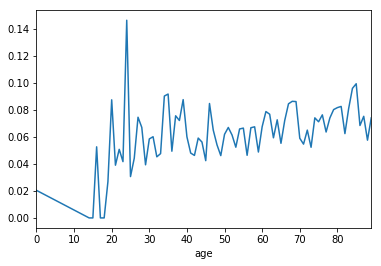

In [40]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

age_groupby = data.groupby(['age'])['readmitted_flag'].sum() / data.groupby(['age'])['readmitted_flag'].count()

age_groupby.plot(kind='line')

This shows that older people tend to be admitted more.  It shows that there is a data quality issue with age, which the imputation has made more prevalent.

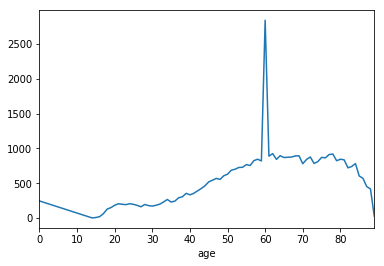

In [41]:
data.groupby(['age'])['readmitted_flag'].count().plot(kind='line')

This shows that married people have a lower tendency of being readmitted versus single and widowed patients

In [42]:
maritalstatus_groupby = data.groupby(['marital_status'])['readmitted_flag'].sum() / data.groupby(['marital_status'])['readmitted_flag'].count()

maritalstatus_groupby.sort_values(ascending=0)

marital_status
SEPARATED            0.101031
SINGLE               0.074984
DIVORCED             0.074334
WIDOWED              0.069771
MARRIED              0.065024
UNKNOWN (DEFAULT)    0.041045
LIFE PARTNER         0.000000
Name: readmitted_flag, dtype: float64

The data analysis shows that there is not a definite chararactistics that are strongly correlated with readmissions, but there are some patterns that may be used to predict readmissions.

Correleation Test

The correlation test using the non-categorical variables within the dataset shows that the correlation of the variables are relatively low compared to the readmitted_flag.  The variables were the most correlated are the visits_prior_30_days, non_elective_visits_prior_30_days, visits_prior_year, and nonelective_visits_prior_year.  All four variables had a correlation value of 0.17.

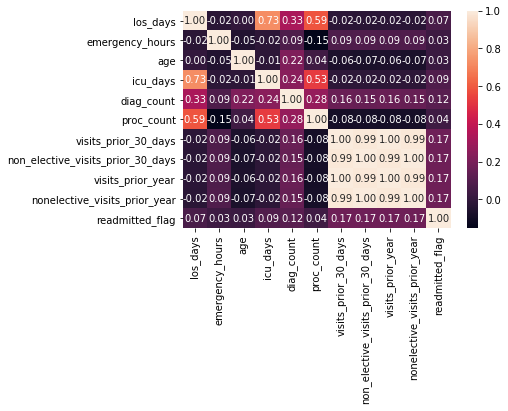

In [43]:
sns.heatmap(data[['los_days','emergency_hours','age','icu_days','diag_count','proc_count','visits_prior_30_days','non_elective_visits_prior_30_days','visits_prior_year','nonelective_visits_prior_year','readmitted_flag']].corr(), annot=True, fmt=".2f")

This shows that the top 10 primary diagnoses for readmitted patients.  As expected, these diagnoses are inline with high acuity.  As expected, high acuity diagnosis such as septicemia (sepsis), respiratory failure, and heart related diagnoses are contained in the top 10.

In [44]:
primarydiag_groupby = data.groupby(['primary_diag'])['readmitted_flag'].sum()

primarydiag_groupby.sort_values(ascending=0).head(10)

primary_diag
Unspecifiedsepticemia                            136
Acuterespiratoryfailure                          112
Coronaryatherosclerosisofnativecoronaryartery    106
Subendocardialinfarctioninitialepisodeofcare      72
Pneumoniaorganismunspecified                      54
Congestiveheartfailureunspecified                 48
Aorticvalvedisorders                              47
Acuteonchronicsystolicheartfailure                45
Pneumonitisduetoinhalationoffoodorvomitus         42
Hemorrhageofgastrointestinaltractunspecified      39
Name: readmitted_flag, dtype: int64

Also, the top 10 primary diag based on readmission % with more than 50 admissions.  The results are similiar to the top 10 by count.

In [45]:
primarydiag_greaterby_groupby = data.groupby(['primary_diag'])['readmitted_flag'].count()
primarydiag_greaterby_groupby = list(primarydiag_greaterby_groupby.where(primarydiag_greaterby_groupby>50).dropna().index)

primarydiag_readmission_groupby = data[data['primary_diag'].isin(primarydiag_greaterby_groupby)].groupby(['primary_diag'])['readmitted_flag'].sum()/data[data['primary_diag'].isin(primarydiag_greaterby_groupby)].groupby(['primary_diag'])['readmitted_flag'].count()
primarydiag_readmission_groupby.sort_values(ascending=0).head(10)

primary_diag
HypertensivechronickidneydiseasemalignantwithchronickidneydiseasestageVorendstagerenaldisease      0.393617
Otherandunspecifiedinfectionduetocentralvenouscatheter                                             0.242857
Acuteonchroniccombinedsystolicanddiastolicheartfailure                                             0.175258
Acuteandchronicrespiratoryfailure                                                                  0.174603
Acuteonchronicsystolicheartfailure                                                                 0.172414
Hypotensionunspecified                                                                             0.168675
HypertensivechronickidneydiseaseunspecifiedwithchronickidneydiseasestageVorendstagerenaldisease    0.160000
Cirrhosisofliverwithoutmentionofalcohol                                                            0.157534
Hepaticencephalopathy                                                                              0.152174
Obstructivechro

This shows that the top 10 primary procedures for readmitted patients.  As expected, the top procedures are intensive procedures.

In [46]:
primaryproc_groupby = data.groupby(['primary_proc'])['readmitted_flag'].sum()

primaryproc_groupby.sort_values(ascending=0).head(10)

primary_proc
None                                                                    341
Continuousinvasivemechanicalventilationforlessthan96consecutivehours    180
Venouscatheterizationnotelsewhereclassified                             162
Temporarytracheostomy                                                   117
Hemodialysis                                                            112
Continuousinvasivemechanicalventilationfor96consecutivehoursormore      109
Otherendoscopyofsmallintestine                                           68
Openandotherreplacementofaorticvalvewithtissuegraft                      54
Percutaneousabdominaldrainage                                            40
Insertionofendotrachealtube                                              40
Name: readmitted_flag, dtype: int64

This shows the top 10 drg for readmitted patients.  The results mirror the top 10 diagnoses where septicemia and other high acuity illnesses are at the top of the readmission count by drg.

In [47]:
drg_groupby = data.groupby(['drg'])['readmitted_flag'].sum()

drg_groupby.sort_values(ascending=0).head(10)

drg
SepticemiaDisseminatedInfections                                  131
HeartFailure                                                       83
PulmonaryEdemaRespiratoryFailure                                   66
TracheostomyWLongTermMechanicalVentilationWExtensiveProcedure      63
RenalFailure                                                       62
TracheostomyWLongTermMechanicalVentilationWOExtensiveProcedure     51
CardiacValveProcedureswoCardiacCatheterization                     49
MajorRespiratoryInfectionsInflammations                            45
RESPIRATORYSYSTEMDIAGNOSISWITHVENTILATORSUPPORT                    42
OtherPneumonia                                                     39
Name: readmitted_flag, dtype: int64

Also, the top 10 drgs based on readmission % with more than 50 admissions.  The interesting observation is that drug or alcohol abuse patients who left against medical advice have the highest readmission rate out of all the drgs.  Interstingly enough, 2 out of the 3 top drgs are alcohol related.  Also, there are 4 tracheostomy related drgs within the top 10.  Tracheostomy is the surgical procedure where a hole is created within the trachea to faciliate mechanical respiration.

In [48]:
drg_greaterby_groupby = data.groupby(['drg'])['readmitted_flag'].count()
drg_greaterby_groupby = list(drg_greaterby_groupby.where(drg_greaterby_groupby>50).dropna().index)

drg_readmission_groupby = data[data['drg'].isin(drg_greaterby_groupby)].groupby(['drg'])['readmitted_flag'].sum()/data[data['drg'].isin(drg_greaterby_groupby)].groupby(['drg'])['readmitted_flag'].count()
drg_readmission_groupby.sort_values(ascending=0).head(10)

drg
DrugAlcoholAbuseorDependenceLeftAgainstMedicalAdvice                                                                                    0.235294
PULMONARYEDEMARESPIRATORYFAILURE                                                                                                        0.185185
CIRRHOSISALCOHOLICHEPATITIS                                                                                                             0.179487
MalfunctionReactionCompofCardiacorVascDeviceorProc                                                                                      0.178295
DIABETESAGE0-35                                                                                                                         0.177215
ECMOORTRACHEOSTOMYWITHMECHANICALVENTILATION96HOURSORPRINCIPALDIAGNOSESEXCEPTFACEMOUTHANDNECKDIAGNOSESWITHMAJOROPERATINGROOMPROCEDURE    0.170886
TracheostomyWLongTermMechanicalVentilationWExtensiveProcedure                                                                 

In summary, there were definite patterns that showed readmission rates were different across aggregations of patients. However, these patterns were highly predictive of readmission due to the complexity and the multitude of factors that can influence whether a patient is readmitted or not.

## Methodology - Implementation

### Additional Data Preprocessing

The data needs to be transformed to be able to use in machine learning.

The first step is to convert all the categorical variables into the dummy variables

In [49]:
data_new = data

cat_vars = ['admission_type','admission_location','discharge_location','insurance','marital_status','drg','primary_diag','primary_proc']

for c in cat_vars:
    # for each cat add dummy var, drop original column
    data_new = pd.concat([data_new.drop([c], axis=1), pd.get_dummies(data_new[c], prefix=c, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

The second step is transform the secondary diagnoses and procedures datasets then generate matrices for the secondary diagnoses and procedures and join them into the main dataset.

The secondary diagnoses dataset was cleaned and pivoted to generate the approrpiate data structure.

In [50]:
# remove special characters, pivot the data, and then join them to the main dataset
sec_diag_data['long_title'] = sec_diag_data['long_title'].apply(lambda x : re.sub('[^a-zA-Z0-9-_*.]', '', str(x)))
sec_diag_data['count'] = 1
sec_diag_data = sec_diag_data.pivot(index='hadm_id', columns = 'long_title', values='count')

sec_diag_data.head(5)

long_title,0414,1730,1731,1732,1733,1734,1735,1736,1737,1738,...,Weboflarynx,Wegenersgranulomatosis,WestNileFeverwithotherneurologicmanifestation,Wheelchairdependence,Wheezing,Whoopingcoughduetootherspecifiedorganism,Wristdropacquired,Wristjointreplacement,Wrongfluidininfusion,ZygomycosisPhycomycosisorMucormycosis
hadm_id,,,,,,,,,,,,,,,,,,,,,
100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


next, the secondary procedures dataset was cleaned and pivoted to generate the appropriate data structure.

In [51]:
sec_proc_data['long_title'] = sec_proc_data['long_title'].apply(lambda x : re.sub('[^a-zA-Z0-9-_*.]', '', str(x)))
sec_proc_data['count'] = 1
sec_proc_data = sec_proc_data.pivot(index='hadm_id', columns = 'long_title', values='count')

sec_proc_data.head(5)

long_title,022,323,324,325,3601,3602,3605,374,398,458,...,Venouscatheterizationnotelsewhereclassified,Venouscutdown,Ventricularshunttoabdominalcavityandorgans,VentricularshunttoextracranialsiteNEC,Ventricularshunttostructureinheadandneck,Ventricularshunttothoraciccavity,Ventriculopuncturethroughpreviouslyimplantedcatheter,Videoandradio-telemeteredelectroencephalographicmonitoring,Vitalcapacitydetermination,Wideexcisionoflesionoflip
hadm_id,,,,,,,,,,,,,,,,,,,,,
100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Both datasets were joined into the main dataset.

In [52]:
data_new.merge(sec_proc_data, left_on='hadm_id', right_index=True, how='left')
data_new.merge(sec_diag_data, left_on='hadm_id', right_index=True, how='left')

data_new.head(5)

,hadm_id,los_days,emergency_hours,age,icu_days,diag_count,proc_count,visits_prior_30_days,non_elective_visits_prior_30_days,visits_prior_year,...,primary_proc_Ureteralcatheterization,primary_proc_Urinarydiversiontointestine,primary_proc_Venouscatheterizationforrenaldialysis,primary_proc_Venouscatheterizationnotelsewhereclassified,primary_proc_Venouscutdown,primary_proc_Ventricularshunttoabdominalcavityandorgans,primary_proc_VentricularshunttoextracranialsiteNEC,primary_proc_Ventriculopuncturethroughpreviouslyimplantedcatheter,primary_proc_Videoandradio-telemeteredelectroencephalographicmonitoring,primary_proc_nan
1,145834,10.750000,0.25,76.0,6.0646,9,6.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,185777,7.750000,0.00,47.0,1.6785,9,3.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,107064,16.333333,0.00,65.0,3.6729,8,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,143045,6.833333,0.00,39.0,3.6660,5,5.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,161087,4.000000,0.30,47.0,0.8795,8,3.0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


The last step is to replace any NaNs with zeroes and remove the hadm_id, which was used to join the datasets.

In [41]:
# fill all nans with 0
data_new = data_new.fillna(0)
data_new = data_new.reset_index()

# remove hadm_id.  it is no longer needed
data_new = data_new.drop(['hadm_id','index'], axis = 1)

There will be two datasets that will be used for machine learning.  The first dataset will contain all the data excluding the secondary diagnoses and procedures.  The second dataset will contains all variables.

Both datasets will be split into a feature and target dataset using stratified shuffle split to ensure that the target variable percentages are the same in both datasets.

In [42]:
# Filter the datasets
data_one = data_new.loc[:,'los_days':'primary_proc_nan']
data_two = data_new

# Split into features and target datasets
features = data_one.drop('readmitted_flag', axis = 1)
target = data_one['readmitted_flag']

features_two = data_two.drop('readmitted_flag', axis = 1)
target_two = data_two['readmitted_flag']

The target is imbalanced with only 6.7% of the admission resulted in readmissions.

In [43]:
print(target.sum()/target.count())

0.0672158154859967


Since the target is imbalanced, stratified shuffle split is used to ensure that both the training and testing datasets have the same proportion of target variables.

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.4, random_state =319)

for train_index, test_index in sss.split(features,target):
    features_train, target_train = features.iloc[train_index], target.iloc[train_index]
    features_test, target_test = features.iloc[test_index], target.iloc[test_index]
    
    features_train_two, target_train_two = features.iloc[train_index], target.iloc[train_index]
    features_test_two, target_test_two = features_two.iloc[test_index], target_two.iloc[test_index]
    
# verify that the stratified 
print(target_train.sum()/target_train.count())
print(target_test.sum()/target_test.count())

0.06723150545226328
0.06719228053659684


### Baseline

Since this is an imbalance classification problem, the baseline is simply assuming that none of the admissions will be readmitted again.

This results in a baseline of 93.28%, which leaves very little room for improvement.

In [45]:
1 - (target_test.sum()/target_test.count())

0.9328077194634031

### Model Selection

Logicistic Regression, Random Forest, AdaBoost, and XGBoost will be evaluated to determine which model to use and improve on.

In [46]:
# import the machine learning and evaluation metric libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb

def print_evaluation_metrics(t_train, p_train, t_test, p_test):
    '''
    This function takes in the targets and predictions for both the training and testing datasets.
    Then the function prints out the evaluation metrics.
    
    Nothing is returned
    '''

    baseline_test = (1-(t_test.sum()/t_test.count()))
    
    acc_train = accuracy_score(t_train, p_train)       
    acc_test = accuracy_score(t_test, p_test)
    auc_test = roc_auc_score(t_test, p_test)
    con_fus_test = confusion_matrix(t_test, p_test)
    
    print('baseline is ' + str(baseline_test))
    print('train accuracy: ' + str(acc_train))
    print('test accuracy: ' + str(acc_test))
    print('test auc_score: ' + str(auc_test))
    print('test confusion matrix: ')
    print(con_fus_test)

D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [47]:
# log reg
lr_model = LogisticRegression(solver = 'saga', random_state=319)
lr_model = lr_model.fit(features_train, target_train)

pred_train = lr_model.predict(features_train)
pred_test = lr_model.predict(features_test)

print('Logistic Regression Results:')
print_evaluation_metrics(target_train, pred_train, target_test, pred_test)
print('')

# rf
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(features_train, target_train)

pred_train = rf_model.predict(features_train)
pred_test = rf_model.predict(features_test)

print('Random Forest Results:')
print_evaluation_metrics(target_train, pred_train, target_test, pred_test)
print('')

# ada
ada_model = AdaBoostClassifier()
ada_model = ada_model.fit(features_train, target_train)

pred_train = ada_model.predict(features_train)
pred_test = ada_model.predict(features_test)

print('AdaBoost Results:')
print_evaluation_metrics(target_train, pred_train, target_test, pred_test)
print('')

# xgboost

xgb_model = xgb.XGBClassifier()
xgboost = xgb_model.fit(features_train, target_train)

pred_train = xgboost.predict(features_train)
pred_test = xgboost.predict(features_test)

print('XGBoost Results:')
print_evaluation_metrics(target_train, pred_train, target_test, pred_test)
print('')

D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression Results:
baseline is 0.9328077194634031
train accuracy: 0.9328469443790696
test accuracy: 0.9322193457284067
test auc_score: 0.5049663998345675
test confusion matrix: 
[[15831    23]
 [ 1129    13]]

Random Forest Results:
baseline is 0.9328077194634031
train accuracy: 0.9866243037577469
test accuracy: 0.9320428336079077
test auc_score: 0.5056843676658086
test confusion matrix: 
[[15826    28]
 [ 1127    15]]

AdaBoost Results:
baseline is 0.9328077194634031
train accuracy: 0.932611594885071
test accuracy: 0.9325723699694045
test auc_score: 0.5071870794732228
test confusion matrix: 
[[15832    22]
 [ 1124    18]]



D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost Results:
baseline is 0.9328077194634031
train accuracy: 0.9333568682827332
test accuracy: 0.9329253942104024
test auc_score: 0.5020945285096029
test confusion matrix: 
[[15851     3]
 [ 1137     5]]



D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Based on the results for the 4 machine learning algorithms, it shows that there is not much improvement in accuracy compared to the baseline and the ROC AUC scores are extremely poor.

Test Accuracy Scores
Logistic Regression = 0.9322
RandomForest = 0.9320
AdaBoost = 0.9325
XGBoost = 0.9329

However, the XGBoost produces the best accuracy in comparison even though the improvement is minor.  It is 0.0001 improvement over the baseline.  XGBoost will be used for further tuning.

## Methodology - Refinement

### Parameter Tuning and Feature Selection

The learning rate, depth, and number of estimators will be tuned by running the model using different parameters.

In [49]:
# import the feature selection library
from sklearn import feature_selection

def tune_xgboost_parameters(features_train, target_train, features_test, target_test, est, lr, depth):
    '''
    This function takes in the feature and target datasets along with a list of estimators, learning rates, and depth.
    This function then runs the model using every combination of estimators, learning rates, and depth and records the accuracy
    This function then returns the results in a dataframe along with the predictions for the training and testing datasets
    '''
    # initalize variables
    acc_list_train = []
    acc_list_test = []
    
    est_list = []
    lr_list = []
    dep_list = []
    
    n_est = 0
    results = pd.DataFrame()

    for e in est:
        for l in lr:
            for d in depth:
                xgboost_model = xgb.XGBClassifier(n_estimators = e, learning_rate = l, max_depth = d)#, random_state = 319)
                
                xgboost_model.fit(features_train, target_train)
                pred_test = xgboost_model.predict(features_test)
                pred_train = xgboost_model.predict(features_train)
                
                acc_train = accuracy_score(target_train, pred_train)       
                
                acc_test = accuracy_score(target_test, pred_test)
    
                #print (acc_train)
                #print (acc_test)
                
                est_list.append(e)
                lr_list.append(l)
                dep_list.append(d)
                acc_list_train.append(acc_train)
                acc_list_test.append(acc_test)
    
    results = pd.DataFrame(
            {'est': est_list,
            'lr': lr_list,
            'depth': dep_list,
            'acc_train': acc_list_train,
            'acc_test': acc_list_test
            })
    
    #results.to_csv('results.csv')
    return results, pred_train, pred_test

def select_xgboost_features(features_train, target_train, features_test, target_test, final_est, final_lr, final_depth, per):
    '''
    This function takes in the feature and training datasets along with the single value for the estimator, learning rate, and depth.
    The per contains the list of percentiles to use for the SelectPercentile function
    This function then returns the results in a dataframe along with the predictions for the training and testing datasets
    '''
    
    
    acc_list_train = []
    acc_list_test = []
    
    per_list = []
    
    percentile = per
    
    # identify the percentile that will produce the best results 
    for per in percentile:
        
        # intilaize SelectFromModel using thresh
        fs = feature_selection.SelectPercentile(feature_selection.f_classif, percentile = per)
        feature_model =  fs.fit(features_train,target_train)
    
        features_train_new = feature_model.transform(features_train)
        features_test_new = feature_model.transform(features_test)
    
        xgboost_model = xgb.XGBClassifier(n_estimators = final_est, learning_rate = final_lr, max_depth = final_depth)#, random_state = 319)
        
        xgboost_model.fit(features_train_new, target_train)
        pred_test = xgboost_model.predict(features_test_new)
        pred_train = xgboost_model.predict(features_train_new)
        
        acc_train = accuracy_score(target_train, pred_train)       
        acc_test = accuracy_score(target_test, pred_test)
    
        #print (acc_train)
        #print (acc_test)
        
        per_list.append(per)
        acc_list_train.append(acc_train)
        acc_list_test.append(acc_test)
    
    per_results = pd.DataFrame(
            {'per': per_list,
            'acc_train': acc_list_train,
            'acc_test': acc_list_test
            })
    
    #per_results.to_csv('per_results.csv')
    return per_results, pred_train, pred_test

### First Model

#### Parameter Tuning

After running the model through parameter tuning, the best parameters for XGBoost Model was the following:

Estimators = 30
Learning Rate = 0.1a
Depth = 6

The testing accuracy improved to 0.9332, which is a slight improvement over the base XGBoost model.

In [50]:
#est = [10,20,30,40,50,50,100,150,200,500,1000]
#lr = [0.1,0.01,0.001,0.0001]
#depth = [4,5,6,7,8,9,10]

est = [30]
lr = [0.1]
depth = [6]

data_one_tuned_results, data_one_pred_train, data_one_pred_test = tune_xgboost_parameters(features_train, target_train, features_test, target_test, est, lr, depth)
print(data_one_tuned_results)

print_evaluation_metrics(target_train, data_one_pred_train, target_test, data_one_pred_test)

D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9347689652467247
0.9332784184514004
   acc_test  acc_train  depth  est   lr
0  0.933278   0.934769      6   30  0.1
baseline is 0.9328077194634031
train accuracy: 0.9347689652467247
test accuracy: 0.9332784184514004
test auc_score: 0.5059403705043195
test confusion matrix: 
[[15848     6]
 [ 1128    14]]


D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Features Selection

After running the tuned model through feature selection, the best percentile was the 10th percentile.  However the testing accuracy did not improve.

In [51]:
final_est = 30
final_lr = 0.1
final_depth = 6

#per = range(1,100)
per = [82]
    
data_one_features_selections_results, data_one_pred_train, data_one_pred_test = select_xgboost_features(features_train, target_train, features_test, target_test, final_est, final_lr, final_depth, per)
print(data_one_features_selections_results)

print_evaluation_metrics(target_train, data_one_pred_train, target_test, data_one_pred_test)

D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  10   11   14   23   38   39   44   58   64   66   75   76   83  101
  112  113  142  146  151  161  170  174  197  201  202  204  205  264
  265  266  274  277  286  292  309  310  325  331  337  344  355  370
  375  377  378  441  453  454  456  461  462  463  465  467  468  486
  492  496  519  527  571  580  588  590  592  594  595  606  613  616
  618  622  631  637  638  641  649  653  672  676  694  708  713  715
  744  755  764  787  791  796  798  821  851  857  864  865  871  875
  887  896  903  904  906  908  911  912  924  927  931  952  953  964
  970  978  984  996 1002 1004 1005 1019 1022 1025 1028 1041 1053 1054
 1065 1075 1081 1099 1102 1117 1146 1151 1158 1164 1171 1182 1198 1200
 1203 1211 1218 1223 1226 1232 1235 1240 1247 1254 1255 1258 1260 1261
 1277 1286 1289 1292 1300 1319 1321 1338 1343 1349 1353 1363 1367 1368
 1370 1375 1376 1378 1384 13

0.9346905154153918
0.9332195810779007
   acc_test  acc_train  per
0   0.93322   0.934691   10
baseline is 0.9328077194634031
train accuracy: 0.9346905154153918
test accuracy: 0.9332195810779007
test auc_score: 0.5046899609550104
test confusion matrix: 
[[15850     4]
 [ 1131    11]]


D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Second Model

The second dataset contains main dataset along with the secondary diagnosis and procedures.  This will drastically increase the number of feature variables, but the hope is that it will introduce variables that will positively influence the model.

Running the second dataset through the XGBoost model with default parameters, the model produced a testing accuracy of 0.9329.

In [52]:
# xgboost

xgb_model = xgb.XGBClassifier()
xgboost = xgb_model.fit(features_train_two, target_train_two)

pred_train = xgboost.predict(features_train_two)
pred_test = xgboost.predict(features_test_two)

print('XGBoost Results:')
print_evaluation_metrics(target_train_two, pred_train, target_test_two, pred_test)
print('')

D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoost Results:
baseline is 0.9328077194634031
train accuracy: 0.9333568682827332
test accuracy: 0.9329253942104024
test auc_score: 0.5020945285096029
test confusion matrix: 
[[15851     3]
 [ 1137     5]]



D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Parameter Tuning

After running the model through parameter tuning, the best parameters for the second model of XGBoost was the following:

Estimators = 30
Learning Rate = 0.1
Depth = 5

The testing accuracy improved to 0.9334, which is a slight improvement over the first model.

In [53]:
#est = [10,20,30,40,50,50,100,150,200,500,1000]
#lr = [0.1,0.01,0.001,0.0001]
#depth = [4,5,6,7,8,9,10]

est = [30]
lr = [0.1]
depth = [5]

data_two_tuned_results, data_two_pred_train, data_two_pred_test = tune_xgboost_parameters(features_train_two, target_train_two, features_test_two, target_test_two, est, lr, depth)
print(data_two_tuned_results)

print_evaluation_metrics(target_train_two, data_two_pred_train, target_test_two, data_two_pred_test)

D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.934062916764729
0.9333960931983997
   acc_test  acc_train  depth  est   lr
0  0.933396   0.934063      5   30  0.1
baseline is 0.9328077194634031
train accuracy: 0.934062916764729
test accuracy: 0.9333960931983997
test auc_score: 0.5055971554798305
test confusion matrix: 
[[15851     3]
 [ 1129    13]]


D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Features Selection

After running the tuned model through feature selection, the best percentile was the 12th percentile.  

The testing accuracy improved to 0.9335, which is another slight increase over the tuned second model.

In [54]:
final_est = 30
final_lr = 0.1
final_depth = 5

#per = range(1,100)
per = [12]
    
data_two_features_selections_results, data_two_pred_train, data_two_pred_test = select_xgboost_features(features_train_two, target_train_two, features_test_two, target_test_two, final_est, final_lr, final_depth, per)
print(data_two_features_selections_results)

print_evaluation_metrics(target_train_two, data_two_pred_train, target_test_two, data_two_pred_test)

D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  10   11   14   23   38   39   44   58   64   66   75   76   83  101
  112  113  142  146  151  161  170  174  197  201  202  204  205  264
  265  266  274  277  286  292  309  310  325  331  337  344  355  370
  375  377  378  441  453  454  456  461  462  463  465  467  468  486
  492  496  519  527  571  580  588  590  592  594  595  606  613  616
  618  622  631  637  638  641  649  653  672  676  694  708  713  715
  744  755  764  787  791  796  798  821  851  857  864  865  871  875
  887  896  903  904  906  908  911  912  924  927  931  952  953  964
  970  978  984  996 1002 1004 1005 1019 1022 1025 1028 1041 1053 1054
 1065 1075 1081 1099 1102 1117 1146 1151 1158 1164 1171 1182 1198 1200
 1203 1211 1218 1223 1226 1232 1235 1240 1247 1254 1255 1258 1260 1261
 1277 1286 1289 1292 1300 1319 1321 1338 1343 1349 1353 1363 1367 1368
 1370 1375 1376 1378 1384 13

0.9340236918490625
0.9334549305718993
   acc_test  acc_train  per
0  0.933455   0.934024   12
baseline is 0.9328077194634031
train accuracy: 0.9340236918490625
test accuracy: 0.9334549305718993
test auc_score: 0.5056286932620936
test confusion matrix: 
[[15852     2]
 [ 1129    13]]


D:\Users\dkim3\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Results

The best model was the tuned and feature selected the second model.  It produced a testing accuracy of 0.9335.  Compared to the baseline of 0.9328, it is an improvement of 0.0006.  Unfortunately, this model was predictive enough to be useful in a real-world situation.  

If there was access to the source system, there could be more features to incorporate to see if a viable prediction model can be produced.  One of the tasks that I would do is clean up the age to ensure that age is always populated.  Another potential task is to clean up the ICD-9 coding that can be used to map all codes.  For the diagnosis codes, there are CCS categories, which are groups of diagnosis codes that can be used to reduce the variables.

In conclusion, the final model was a slight improvement over the baseline; however, additional work needs to be done to see if a viable model can be produced.